In [193]:
import numpy as np
import matplotlib.pyplot as plt
import random 

def initialize_particles_center_bias(n, radius, center_bias=0.3):
    """ Initialize particles with a bias towards the center. """
    angles = np.random.uniform(0, 2 * np.pi, n)
    radii = radius * np.sqrt(np.random.uniform(0, center_bias, n))  # Bias towards smaller radii
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    return np.column_stack((x, y))

def compute_forces_and_energy_vectorized(particles, radius):
    """ Compute the forces and energy for the current configuration of particles using vectorized operations. """
    n = len(particles)
    diff = particles[:, np.newaxis, :] - particles[np.newaxis, :, :]
    distances = np.linalg.norm(diff, axis=2)
    np.fill_diagonal(distances, np.inf)
    energy = np.sum(1 / distances[np.triu_indices(n, 1)])
    forces = np.sum(diff / distances[:,:,np.newaxis]**2, axis=1)
    return forces, energy

def update_particle_positions(particles, step_size, radius):
    """ Update the positions of particles randomly and handle infinitely hard wall boundary conditions. """
    n = len(particles)
    new_particles = np.copy(particles)

    for i in range(n):
        # Generate a random direction
        angle = np.random.uniform(0, 2 * np.pi)
        direction = np.array([np.cos(angle), np.sin(angle)])

        # Update the particle position in the random direction
        new_particles[i] += direction * step_size * np.random.uniform(0, 2)

        # Check if the particle is outside the boundary
        distance_from_center = np.linalg.norm(new_particles[i])
        
        # if random.random() > distance_from_center**2:
        #     perturbation = np.random.normal(scale=0.5, size=particles[i].shape)
        #     new_particles[i] += perturbation
            
        # distance_from_center = np.linalg.norm(new_particles[i])
        if distance_from_center > radius:
            # If outside, reposition it on the boundary
            new_particles[i] = new_particles[i] / distance_from_center * radius

    return new_particles


def simulate_charged_particles_annealing(n, radius, steps, initial_step_size, final_step_size, initial_temp, final_temp):
    """ Simulate the charged particles with simulated annealing, updating all particles at once. """
    particles = initialize_particles(n, radius)
    min_energy_config = None
    min_energy = np.inf
    energies = []

    temperature = initial_temp
    step_size = initial_step_size

    # Calculate the cooling and step size rates
    cooling_rate = 0.0001 ** (1/steps)
    step_rate = (final_step_size / initial_step_size) ** (1 / steps)

    for step in range(steps):

        forces, current_energy = compute_forces_and_energy_vectorized(particles, radius)

        # Calculate new positions for all particles
        new_particles = update_particle_positions(particles, step_size, radius)
        new_energy = compute_forces_and_energy_vectorized(new_particles, radius)[1]

        # Decide whether to accept the new configuration
        if new_energy < current_energy or np.random.rand() < np.exp((current_energy - new_energy) / temperature):
            particles = new_particles
            current_energy = new_energy

        if step % 1000 == 0:
            print(step, np.exp((current_energy - new_energy) / temperature), temperature)
        # Update energy, temperature, and step size after each step
        energy = compute_forces_and_energy_vectorized(particles, radius)[1]
        energies.append(energy)

        if energy < min_energy:
            min_energy = energy
            min_energy_config = particles.copy()

       
        temperature = initial_temperature * (cooling_rate ** step)
        step_size *= step_rate

    return min_energy_config, min_energy, energies

0 1.0 150
1000 1.0 143.2554849101925
2000 1.0 136.8079259961387
3000 1.0 130.65055503528092
4000 1.0 124.7703114182781
5000 1.0 119.15472236004057
6000 1.0 113.79187644328064
7000 1.0 108.67039835279964
8000 1.0 103.77942474691908
9000 1.0 99.10858121487664
10000 1.0 94.64796027130996
11000 1.0 90.38810034115185
12000 1.0 86.31996569036112
13000 1.0 82.43492725991909
14000 1.0 78.7247443624386
15000 1.0 75.18154720256123
16000 1.0 71.79782018406617
17000 1.0 68.56638596828297
18000 1.0 65.48039024999406
19000 1.0 62.53328721853425
20000 0.7127251644465215 59.71882567324886
21000 0.44588043413688555 57.031035763858895
22000 1.0 54.46421632760827
23000 1.0 52.01292279633322
24000 1.0 49.67195564780325
25000 0.6946326682479378 47.4363493768374
26000 1.0 45.301361962802005
27000 1.0 43.26246481114912
28000 1.0 41.31533314766042
29000 1.0 39.45583684502114
30000 1.0 37.68003166226636
31000 1.0 35.98415087851711
32000 1.0 34.36459730326037
33000 1.0 32.81793564622568
34000 1.0 31.34088523067

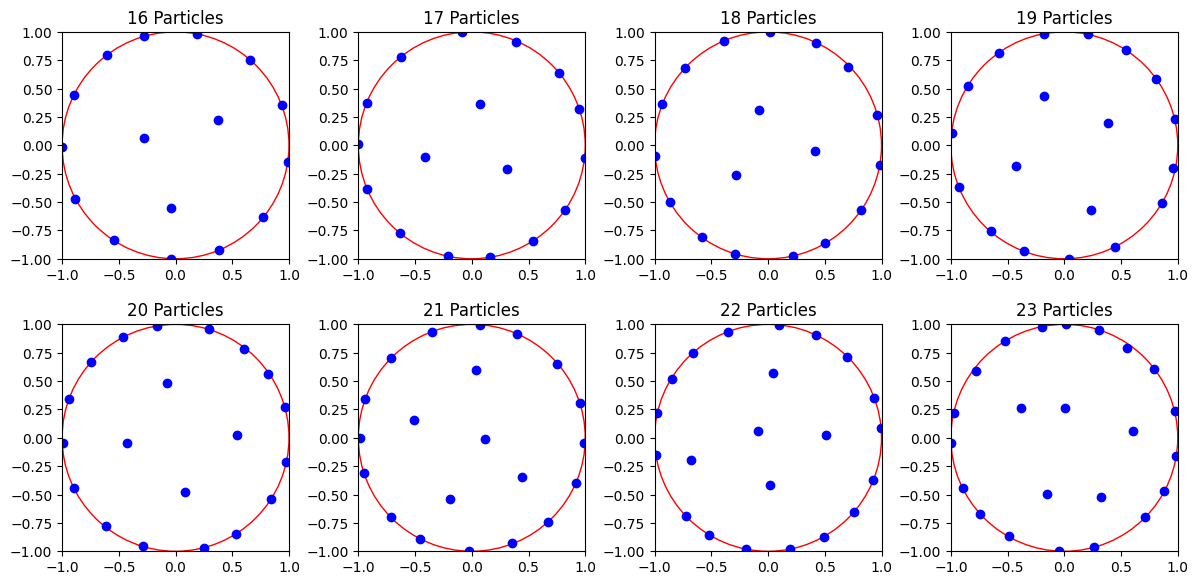

In [140]:

# Parameters
circle_radius = 1
simulation_steps = 200_000
initial_step_size = 0.3
final_step_size = 0.02
initial_temperature = 150
final_temperature = 0.01

# Number of rows and columns in the subplot grid
nrows = 2
ncols = 4

# Create a figure with subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 6))

# Iterate over the specified number of particles
for i, n_particles in enumerate(range(16, 24)):
    # Run the simulation for each particle count
    annealing_particles, _, _ = simulate_charged_particles_annealing(
        n_particles, circle_radius, simulation_steps, initial_step_size, final_step_size, initial_temperature, final_temperature
    )

    # Plot the configuration for each particle count
    ax = axes[i // ncols, i % ncols]  # Select the correct subplot
    circle = plt.Circle((0, 0), circle_radius, color='r', fill=False)
    ax.add_artist(circle)
    ax.scatter(annealing_particles[:, 0], annealing_particles[:, 1], color='blue')
    ax.set_xlim([-circle_radius, circle_radius])
    ax.set_ylim([-circle_radius, circle_radius])
    ax.set_title(f"{n_particles} Particles")
    ax.set_aspect('equal', 'box')

plt.tight_layout()
plt.show()

0 1.0 150
1000 1.0 59.771101457666596
2000 1.0 23.795304082177797
3000 0.48138853007771176 9.473081180615939
4000 0.7944114882885008 3.7713015452386154
5000 1.0 1.5013821874789857
6000 0.7413739296939382 0.5977110145766826
7000 1.0 0.2379530408217846
8000 0.15104133256540006 0.09473081180616201
9000 7.385759526157497e-10 0.0377130154523872


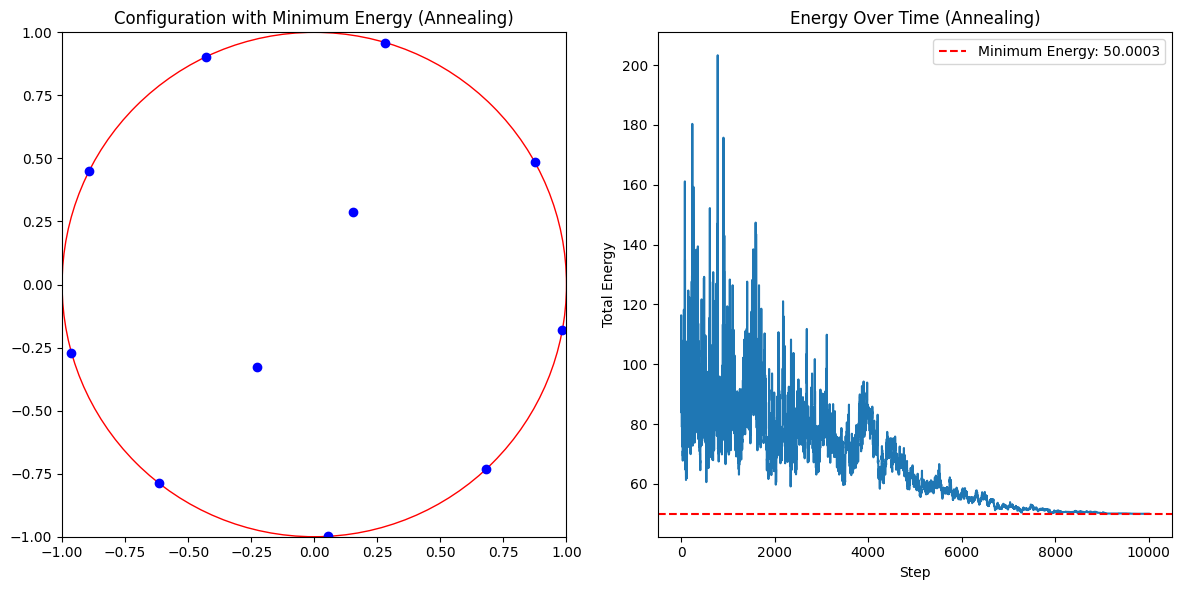

In [175]:

# Parameters
n_particles = 11  # Number of particles
circle_radius = 1
simulation_steps = 10_000
initial_step_size = 0.1
final_step_size = 0.02
initial_temperature = 150
final_temperature = 0.01

# Run the simulation with simulated annealing
annealing_particles, annealing_min_energy, annealing_energy_over_time = simulate_charged_particles_annealing(
    n_particles, circle_radius, simulation_steps, initial_step_size, final_step_size, initial_temperature, final_temperature
)

# Plotting
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Configuration with minimum energy (annealing)
circle = plt.Circle((0, 0), circle_radius, color='r', fill=False)
ax[0].add_artist(circle)
ax[0].scatter(annealing_particles[:, 0], annealing_particles[:, 1], color='blue')
ax[0].set_xlim([-circle_radius, circle_radius])
ax[0].set_ylim([-circle_radius, circle_radius])
ax[0].set_title("Configuration with Minimum Energy (Annealing)")
ax[0].set_aspect('equal', 'box')

# Energy over time (annealing)
ax[1].plot(annealing_energy_over_time)
ax[1].set_title("Energy Over Time (Annealing)")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Total Energy")
ax[1].axhline(y=annealing_min_energy, color='r', linestyle='--', label=f'Minimum Energy: {annealing_min_energy:.4f}')
ax[1].legend()

plt.tight_layout()
plt.show()

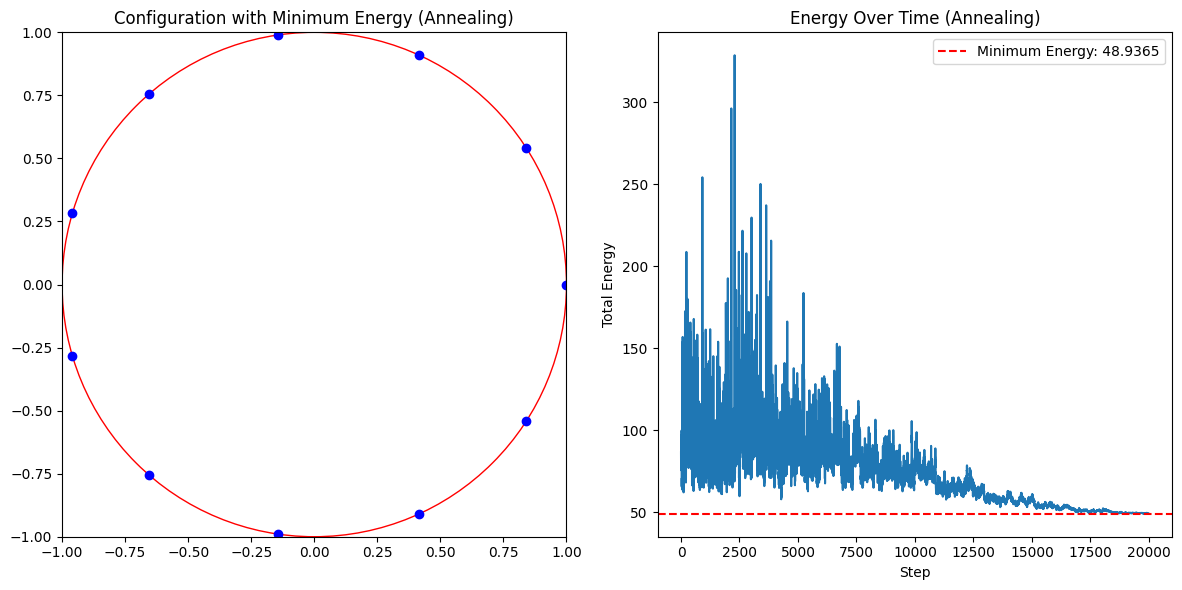

In [197]:

# Parameters
n_particles = 11 # Number of particles
circle_radius = 1
simulation_steps = 20_000
initial_step_size = 0.1
final_step_size = 0.02
initial_temperature = 500
final_temperature = 0.01


# Run the simulation with simulated annealing
annealing_particles, annealing_min_energy, annealing_energy_over_time = simulate_charged_particles_annealing(
    n_particles, circle_radius, simulation_steps, initial_step_size, final_step_size, initial_temperature, final_temperature
)

# Plotting
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Configuration with minimum energy (annealing)
circle = plt.Circle((0, 0), circle_radius, color='r', fill=False)
ax[0].add_artist(circle)
ax[0].scatter(annealing_particles[:, 0], annealing_particles[:, 1], color='blue')
ax[0].set_xlim([-circle_radius, circle_radius])
ax[0].set_ylim([-circle_radius, circle_radius])
ax[0].set_title("Configuration with Minimum Energy (Annealing)")
ax[0].set_aspect('equal', 'box')

# Energy over time (annealing)
ax[1].plot(annealing_energy_over_time)
ax[1].set_title("Energy Over Time (Annealing)")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Total Energy")
ax[1].axhline(y=annealing_min_energy, color='r', linestyle='--', label=f'Minimum Energy: {annealing_min_energy:.4f}')
ax[1].legend()

plt.tight_layout()
plt.show()